In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# Without this line matlib will crash 
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i , c in enumerate(chars)}
stoi ['.'] = 0
itos = {i: c for c , i in stoi.items()}
vocab_size = len(itos)
print (itos)
print (vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset for training, validation and test
block_size = 3 # trigram model

def build_dataset(words):
    block_size = 3 
    X, Y = [], []
    for w in words: 
        context = [0] * block_size # context window [0, 0, 0]
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # add new char in the end and removes the first one

    X = torch.tensor(X) # X has trigram contexts
    Y = torch.tensor(Y) # Y has index of each character that the trigram corresponds to. For example for first letter e, trigram is [0, 0, 0] and Y[0] = 5; for second letter e, trigram is [0, 0, 5] and Y[1] = 5;
    print (X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
 
Xtr, Ytr = build_dataset(words[:n1]) # 80% of the words for training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% 
Xts, Yts = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [44]:
# Let us train a deeper network and pytorchify the MLP code
# Each class Linear, BatchNorm1d, tanh are layers... 

#g = torch.Generator().manual_seed(2147483627)

class Linear: # Similiar to torch.nn.Linear

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)  /(fan_in**0.5) # kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d: # Similiar to torch.nn.BatchNorm1d

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # gain 
        self.beta = torch.zeros(dim) # bias
        # buffer (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # scale and shift
        # update the buffers: running mean and variance
        if self.training:
            with torch.no_grad(): # exponential moving average
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
        
n_embd = 10 # embedding size 
n_hidden = 100 # nuerons in hidden layer in MLP
g = torch.Generator().manual_seed(2147483627)

# Each class Linear, BatchNorm1d, tanh are layers... We can stack them up to create a deep network

C = torch.randn((vocab_size, n_embd), generator=g)  # 27 x 10
layers = [
    Linear(n_embd * block_size, n_hidden),  Tanh(), 
    Linear(         n_hidden, n_hidden) ,  Tanh(),
    Linear(         n_hidden, n_hidden) ,  Tanh(),
    Linear(         n_hidden, n_hidden) ,  Tanh(),
    Linear(         n_hidden, n_hidden) ,  Tanh(),
    Linear(         n_hidden, vocab_size), 
]
# Why Tanh ? Otherwise, if it is just a linear layers then the output is just big linear combination of input. Because of the squashing effect of tanh, It is a non-linear combination of input. We can represent many complex behaviour. 

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 #5/3 # 5/3 is the gain for tanh is necessary to fight the squash effect of tanh. If you give 1 instead of 5/3, the network will not learn anything and saturation point is reached quickly in the stacked layer. If it is 2 or 3 it gets saturate quickly. 5/3 is right amout for stacked linear layer and tanh operation. 
            
paramaters = [C] + [p for layer in layers for p in layer.parameters()]
print ( sum(p.nelement() for p in paramaters) ) # number of parameters in total 
for p in paramaters:
    p.requires_grad = True

46497


In [45]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

# same optimization as last time 
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps): 

  # minibatch construct 
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # 32 random indices
  Xb, Yb = Xtr[ix], Ytr[ix] # 32 x 3, 32 x 1

  # forward pass
  emb = C[Xb] # 32 x 3 x 10
  x = emb.view(emb.shape[0], -1) # 32 x 30
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # 32 x 27, 32 x 1 -> 32 x 1

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in paramaters:
    p.grad = None
  loss.backward() # backward pass

  # updating learning rate
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in paramaters:
    p.data += -lr * p.grad # nudge each node / parameters 

  # track stats
  if i % 10000 == 0:
    print ( f'{i:7d}/{max_steps:7d} loss: {loss.item():.4f}' )
  lossi.append(loss.log10().item()) 

  break # DEBUG: remove this line to run the full training

      0/ 200000 loss: 3.2958


layer 1 (      Tanh) : mean -0.000, std 0.389, saturated: 0.000%
layer 3 (      Tanh) : mean -0.003, std 0.196, saturated: 0.000%
layer 5 (      Tanh) : mean -0.004, std 0.100, saturated: 0.000%
layer 7 (      Tanh) : mean +0.001, std 0.049, saturated: 0.000%
layer 9 (      Tanh) : mean -0.001, std 0.025, saturated: 0.000%


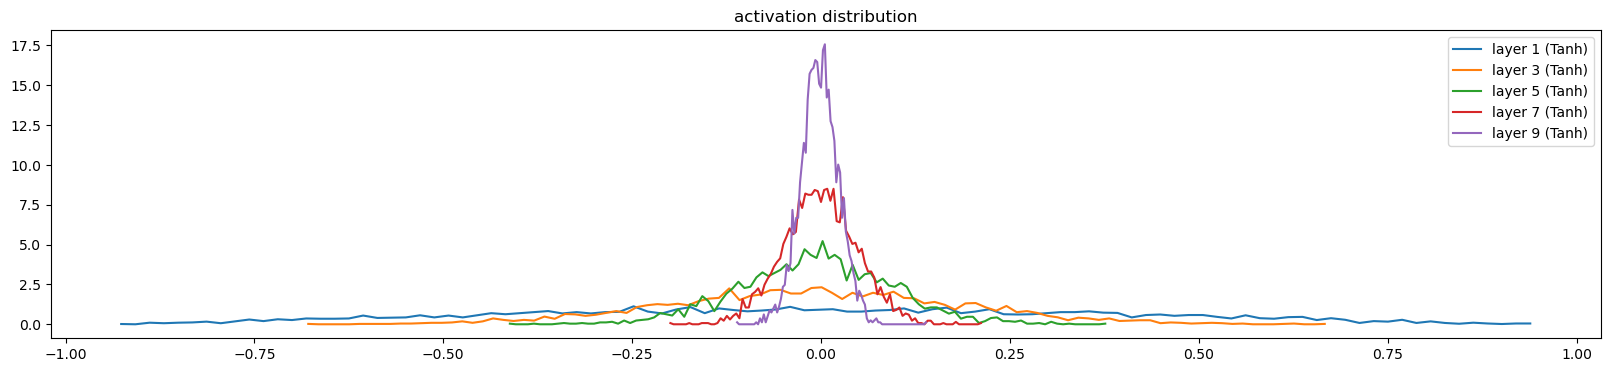

In [46]:
# visualize activation 
# this visualization is used to keep track of forward pass  
plt.figure(figsize=(20, 4)) # width and height of th plot 
legends = []
for i, layer in enumerate(layers[:-1]): # skip the last layer, it is output layer
  if isinstance(layer, Tanh):
    t = layer.out 
    print ( 'layer %d (%10s) : mean %+.3f, std %.3f, saturated: %.3f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
    hy, hx = torch.histogram(t, density=True) 
    plt.plot(hx[:-1].detach(), hy.detach() ) 
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');


layer 1 (      Tanh) : mean -0.000, std 1.781625e-05
layer 3 (      Tanh) : mean +0.000, std 3.498925e-05
layer 5 (      Tanh) : mean +0.000, std 7.148700e-05
layer 7 (      Tanh) : mean +0.000, std 1.500166e-04
layer 9 (      Tanh) : mean -0.000, std 3.115551e-04


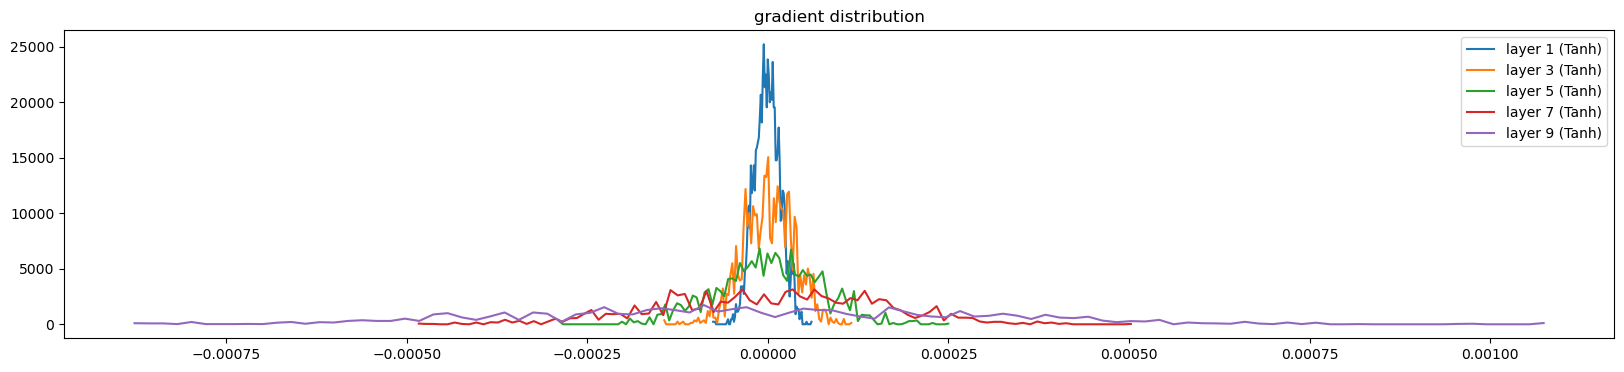

In [47]:
# visualize gradient distribution
# this gradient visualization is used to keep track of backpropagation
plt.figure(figsize=(20, 4)) # width and height of th plot
legends = []
for i, layer in enumerate(layers[:-1]): # skip the last layer, it is output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print ( 'layer %d (%10s) : mean %+.3f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True) 
        plt.plot(hx[:-1].detach(), hy.detach() ) 
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10)| mean +0.000| std 2.522347e-05 | grad:data ratio 2.426530e-05
weight  (30, 100)| mean -0.000| std 8.848287e-05 | grad:data ratio 9.820899e-04
weight (100, 100)| mean +0.000| std 8.088483e-05 | grad:data ratio 1.610388e-03
weight (100, 100)| mean -0.000| std 8.692204e-05 | grad:data ratio 1.739105e-03
weight (100, 100)| mean -0.000| std 1.004333e-04 | grad:data ratio 2.023216e-03
weight (100, 100)| mean -0.000| std 9.605673e-05 | grad:data ratio 1.926074e-03
weight  (100, 27)| mean -0.000| std 8.982281e-04 | grad:data ratio 8.990992e-02


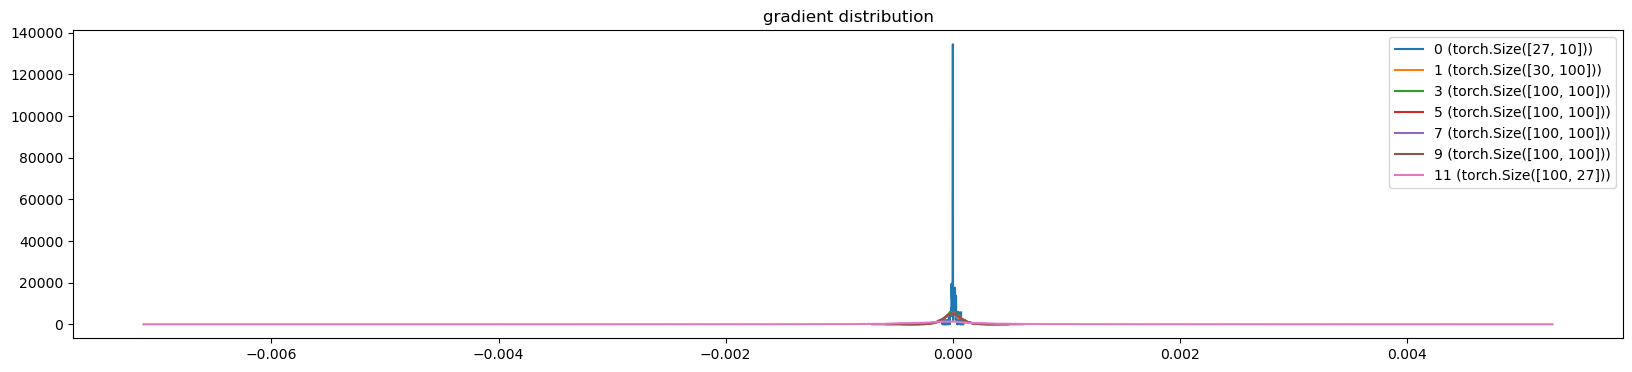

In [50]:
# visualize the parameters 
plt.figure(figsize=(20, 4)) # width and height of th plot
legends = []
for i, p in enumerate(paramaters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s| mean %+.3f| std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach() )
        legends.append(f'{i} ({p.shape})')
plt.legend(legends);
plt.title('gradient distribution');